# Assigment 3 - GraphSage

For this assignment, we'll go through a simple example of how to use GraphSage's algorithm in a similar fashion as [Assignment 1](https://github.com/thmosqueiro/graph-attention-net-genomics-public/blob/main/notebooks/Chapter%201%20-%20Pytorch%20Intro.ipynb). Like before, getting 10 pts in this assignment gives you 100% grade. There are two extra points you can get if you want to go above and beyond (or if you want to catch up from a previous assignment).

For more info:
* https://snap.stanford.edu/graphsage/
* https://arxiv.org/pdf/1706.02216

The original publication uses Tensorflow. PyG (Pytorch Geommetric) implements solutions for Graph NNs, and include GraphSage:
* https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GraphSAGE.html
Here's their implementation of GraphSage (which is reproduced below):
* https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/basic_gnn.html#GraphSAGE

### References
Ni, J., Li, J., & McAuley, J. (2019). Justifying recommendations using distantly-labeled reviews and fine-grained aspects. Empirical Methods in Natural Language Processing (EMNLP).


In case you need to install pyg:

In [1]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import gzip
import json
import random
from torch_geometric.data import Data

In [3]:
# model definition
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, aggr):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels, aggr = aggr)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

In [4]:
# dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

* **Question 1 (1 pt):** Visualize the training data using a classical dimensionality reduction technique.

In [5]:
X = dataset[0].x.numpy()
y = dataset[0].y.numpy()

In [6]:
pca = PCA()
x_pca = pca.fit_transform(X)

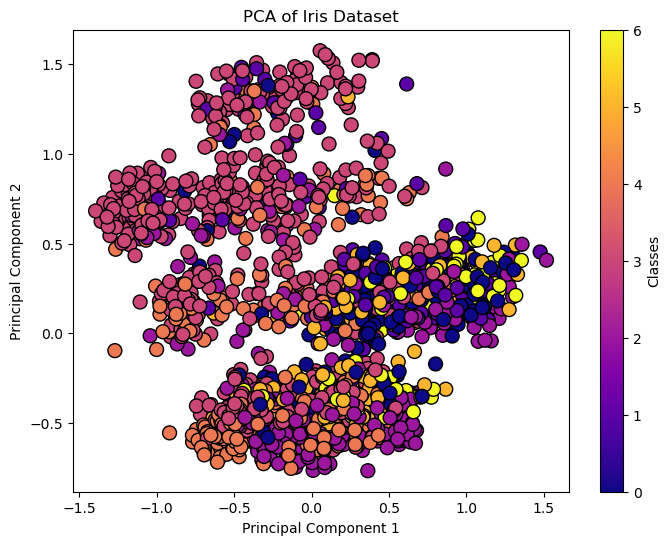

In [7]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='plasma', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Iris Dataset')
plt.colorbar(scatter, label='Classes')
plt.show()

Use `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')` if you'd like to use CUDA.

In [8]:
# Setting up the model
model = GraphSAGE(dataset.num_node_features, dataset.num_classes, 'mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

* **Question 2 (1 pt):** What's "weight decay"?
* **Answer:** Weight decay is L2 regularization which adds a penalty term in the training for the weights, making the training more robust to higher weights and spread the loss evenly. This helps prevent overfitting improves the generalization of the model.

In [9]:
# Defining a training step
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test(model):
    model.eval()
    with torch.no_grad():
        out = model(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc, pred[dataset.data.test_mask], dataset.data.y[dataset.data.test_mask]

In [10]:
# Run one iteration
train(model, optimizer)
acc = test(model)[0]
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.5120


C:\Users\siddu\anaconda3\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [11]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train(model, optimizer)
    accuracy.append(test(model)[0])
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.636
Accuracy on epoch 2: 0.672
Accuracy on epoch 3: 0.68
Accuracy on epoch 4: 0.685
Accuracy on epoch 5: 0.687
Accuracy on epoch 6: 0.688
Accuracy on epoch 7: 0.693
Accuracy on epoch 8: 0.697
Accuracy on epoch 9: 0.7
Accuracy on epoch 10: 0.704
Accuracy on epoch 11: 0.703
Accuracy on epoch 12: 0.705
Accuracy on epoch 13: 0.705
Accuracy on epoch 14: 0.705
Accuracy on epoch 15: 0.703
Accuracy on epoch 16: 0.704
Accuracy on epoch 17: 0.703
Accuracy on epoch 18: 0.704
Accuracy on epoch 19: 0.703
Accuracy on epoch 20: 0.702
Accuracy on epoch 21: 0.701
Accuracy on epoch 22: 0.701
Accuracy on epoch 23: 0.701
Accuracy on epoch 24: 0.697
Accuracy on epoch 25: 0.7
Accuracy on epoch 26: 0.702
Accuracy on epoch 27: 0.701
Accuracy on epoch 28: 0.702
Accuracy on epoch 29: 0.701
Accuracy on epoch 30: 0.702
Accuracy on epoch 31: 0.704
Accuracy on epoch 32: 0.704
Accuracy on epoch 33: 0.704
Accuracy on epoch 34: 0.705
Accuracy on epoch 35: 0.707
Accuracy on epoch 36: 0.707
Accura

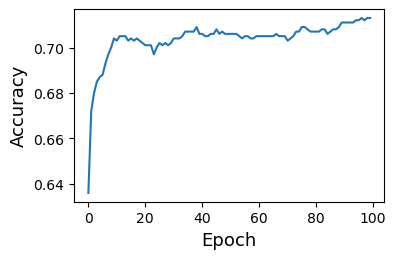

In [12]:
import pylab as pl
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

## Questions

* **Question 3 (1 pt):** Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.

* **Question 4 (1 pt):** Compare this GraphSage with models from Weekly Assignment 2.

* **Question 5 (2 pt):** Change the aggregation function to `max`. What's the default?

* **Question 6 (2 pt):** Add one more layer to the model and investigate the performance change.

* **Question 7 (2 pt):** Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

* **Question 8 (4 pt):** Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice.


Good luck! :)

## Answer 3 ##

In [13]:
accuracy_test, pred_test, y_test = test(model)

In [14]:
cm = confusion_matrix(y_test, pred_test)

In [15]:
for i in range(len(cm)):
    class_accuracy = cm[i][i] / cm[i].sum()
    print(f"Class {i}: {class_accuracy:.3f}")

Class 0: 0.715
Class 1: 0.846
Class 2: 0.799
Class 3: 0.621
Class 4: 0.792
Class 5: 0.709
Class 6: 0.609


- The model does't predict all classes equally well. It does a better job at predicting classes 1,2, 4, and 5 than predicting classes 0, 7, and 6

## Answer 4 ##

- I believe that Random walk GNN performed the best since this classification problem relies more on the graph structure rather than information from node features.
- From the accuracy scores, the performace was Random walk > GCN > GraphSAGE
  I was surprised by the fact that GCN outperformed GraphSAGE, though not by much. I believed that GraphSAGE would do better than GCN as it also uses random walks in it, so it should capture the graph structure better than GCN.
  I think that GraphSAGE wouldn't be able do better than random walk based GNN in this specific task, but should outperform GCN after hyperparameter tuning and finding the best aggregation function.

## Answer 5 ##

In [16]:
SAGEConv?

Init signature:
SAGEConv(
    in_channels: Union[int, Tuple[int, int]],
    out_channels: int,
    aggr: Union[str, List[str], torch_geometric.nn.aggr.base.Aggregation, NoneType] = 'mean',
    normalize: bool = False,
    root_weight: bool = True,
    project: bool = False,
    bias: bool = True,
    **kwargs,
)
Docstring:     
The GraphSAGE operator from the `"Inductive Representation Learning on
Large Graphs" <https://arxiv.org/abs/1706.02216>`_ paper.

.. math::
    \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
    \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j

If :obj:`project = True`, then :math:`\mathbf{x}_j` will first get
projected via

.. math::
    \mathbf{x}_j \leftarrow \sigma ( \mathbf{W}_3 \mathbf{x}_j +
    \mathbf{b})

as described in Eq. (3) of the paper.

Args:
    in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
        derive the size from the first input(s) to the forward method.
        A tuple corresponds to the 

- The default aggregation function is mean. 

In [17]:
model_max = GraphSAGE(dataset.num_node_features, dataset.num_classes, 'max')
optimizer_max = torch.optim.Adam(model_max.parameters(), lr=0.01, weight_decay=5e-4)

In [18]:
accuracy_max = []
for epoch in range(100):
    train(model_max, optimizer_max)
    accuracy_max.append(test(model_max)[0])
    print(f'Accuracy on epoch {epoch+1}: {accuracy_max[-1]}')

C:\Users\siddu\anaconda3\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.463
Accuracy on epoch 2: 0.616
Accuracy on epoch 3: 0.674
Accuracy on epoch 4: 0.7
Accuracy on epoch 5: 0.708
Accuracy on epoch 6: 0.709
Accuracy on epoch 7: 0.708
Accuracy on epoch 8: 0.71
Accuracy on epoch 9: 0.71
Accuracy on epoch 10: 0.705
Accuracy on epoch 11: 0.7
Accuracy on epoch 12: 0.697
Accuracy on epoch 13: 0.698
Accuracy on epoch 14: 0.695
Accuracy on epoch 15: 0.696
Accuracy on epoch 16: 0.698
Accuracy on epoch 17: 0.698
Accuracy on epoch 18: 0.696
Accuracy on epoch 19: 0.695
Accuracy on epoch 20: 0.694
Accuracy on epoch 21: 0.694
Accuracy on epoch 22: 0.695
Accuracy on epoch 23: 0.695
Accuracy on epoch 24: 0.693
Accuracy on epoch 25: 0.695
Accuracy on epoch 26: 0.694
Accuracy on epoch 27: 0.694
Accuracy on epoch 28: 0.694
Accuracy on epoch 29: 0.694
Accuracy on epoch 30: 0.694
Accuracy on epoch 31: 0.695
Accuracy on epoch 32: 0.694
Accuracy on epoch 33: 0.695
Accuracy on epoch 34: 0.696
Accuracy on epoch 35: 0.695
Accuracy on epoch 36: 0.694
Accurac

## Answer 6 ##

In [19]:
class GraphSAGE_q6(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, aggr):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr=aggr)
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr=aggr)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [20]:
dataset.num_node_features, dataset.num_classes

(1433, 7)

In [21]:
model_q6 = GraphSAGE_q6(dataset.num_node_features, 256, dataset.num_classes, "max")
optimizer_q6 = torch.optim.Adam(model_q6.parameters(), lr=0.01, weight_decay=5e-4)

In [22]:
accuracy_q6 = []
for epoch in range(100):
    train(model_q6, optimizer_q6)
    accuracy_q6.append(test(model_q6)[0])
    print(f'Accuracy on epoch {epoch+1}: {accuracy_q6[-1]}')

Accuracy on epoch 1: 0.268
Accuracy on epoch 2: 0.646
Accuracy on epoch 3: 0.537
Accuracy on epoch 4: 0.575
Accuracy on epoch 5: 0.63
Accuracy on epoch 6: 0.69
Accuracy on epoch 7: 0.731
Accuracy on epoch 8: 0.743
Accuracy on epoch 9: 0.756
Accuracy on epoch 10: 0.753
Accuracy on epoch 11: 0.753
Accuracy on epoch 12: 0.749
Accuracy on epoch 13: 0.748
Accuracy on epoch 14: 0.742
Accuracy on epoch 15: 0.742
Accuracy on epoch 16: 0.745
Accuracy on epoch 17: 0.746
Accuracy on epoch 18: 0.742
Accuracy on epoch 19: 0.742
Accuracy on epoch 20: 0.74
Accuracy on epoch 21: 0.74
Accuracy on epoch 22: 0.743
Accuracy on epoch 23: 0.74
Accuracy on epoch 24: 0.738
Accuracy on epoch 25: 0.74
Accuracy on epoch 26: 0.745
Accuracy on epoch 27: 0.743
Accuracy on epoch 28: 0.746
Accuracy on epoch 29: 0.747
Accuracy on epoch 30: 0.75
Accuracy on epoch 31: 0.749
Accuracy on epoch 32: 0.748
Accuracy on epoch 33: 0.75
Accuracy on epoch 34: 0.75
Accuracy on epoch 35: 0.751
Accuracy on epoch 36: 0.751
Accuracy o

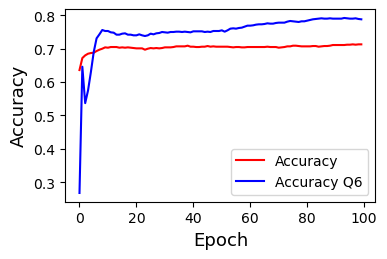

In [23]:
import pylab as pl

f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-', color='red', label='Accuracy')
ax.plot(accuracy_q6, '-', color='blue', label='Accuracy Q6')

ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
ax.legend()

pl.show()

- It seems like the model with the hidden layer starts off with a lower accuracy, but starts outperforming the original model consistently after about 20 epochs. 

## Answer 7 ##

In [24]:
class GraphSAGE_q7(torch.nn.Module):
    def __init__(self, in_channels, out_channels, aggr):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels, aggr = aggr)
        self.dropout = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return F.log_softmax(x, dim=1)

In [25]:
model_q7 = GraphSAGE_q7(dataset.num_node_features, dataset.num_classes, "max")
optimizer_q7 = torch.optim.Adam(model_q7.parameters(), lr=0.01, weight_decay=5e-4)

In [26]:
accuracy_q7 = []
for epoch in range(100):
    train(model_q7, optimizer_q7)
    accuracy_q7.append(test(model_q7)[0])
    print(f'Accuracy on epoch {epoch+1}: {accuracy_q7[-1]}')

Accuracy on epoch 1: 0.408
Accuracy on epoch 2: 0.574
Accuracy on epoch 3: 0.646
Accuracy on epoch 4: 0.664
Accuracy on epoch 5: 0.682
Accuracy on epoch 6: 0.697
Accuracy on epoch 7: 0.711
Accuracy on epoch 8: 0.717
Accuracy on epoch 9: 0.728
Accuracy on epoch 10: 0.73
Accuracy on epoch 11: 0.731
Accuracy on epoch 12: 0.735
Accuracy on epoch 13: 0.732
Accuracy on epoch 14: 0.73
Accuracy on epoch 15: 0.727
Accuracy on epoch 16: 0.723
Accuracy on epoch 17: 0.723
Accuracy on epoch 18: 0.722
Accuracy on epoch 19: 0.72
Accuracy on epoch 20: 0.715
Accuracy on epoch 21: 0.714
Accuracy on epoch 22: 0.713
Accuracy on epoch 23: 0.713
Accuracy on epoch 24: 0.714
Accuracy on epoch 25: 0.714
Accuracy on epoch 26: 0.715
Accuracy on epoch 27: 0.712
Accuracy on epoch 28: 0.714
Accuracy on epoch 29: 0.717
Accuracy on epoch 30: 0.716
Accuracy on epoch 31: 0.717
Accuracy on epoch 32: 0.718
Accuracy on epoch 33: 0.718
Accuracy on epoch 34: 0.72
Accuracy on epoch 35: 0.72
Accuracy on epoch 36: 0.721
Accura

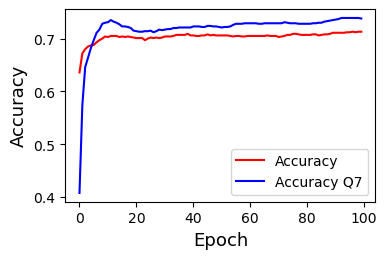

In [27]:
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-', color='red', label='Accuracy')
ax.plot(accuracy_q7, '-', color='blue', label='Accuracy Q7')

ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
ax.legend()

pl.show()

## Answer 8 ##

In [28]:
with gzip.open('data/Appliances_5.json.gz',  'rt') as f:
    lines = f.readlines()

In [29]:
appliances_df = pd.DataFrame([json.loads(line) for line in lines])
appliances_df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something tha...,Great product,1377129600,NaN,NaN
1,5.0,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN
2,5.0,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN
3,5.0,True,"04 24, 2015",AR3OHHHW01A8E,B00009W3PA,{'Size:': ' 6-Foot'},Calvin E Reames,Good value for electric dryers,Perfect size,1429833600,NaN,NaN
4,5.0,True,"03 21, 2015",A2CIEGHZ7L1WWR,B00009W3PA,{'Size:': ' 6-Foot'},albert j. kong,Price and delivery was excellent.,Five Stars,1426896000,NaN,NaN


In [30]:
appliances_df['average_rating'] = appliances_df.groupby('asin')['overall'].transform('mean')
appliances_df = appliances_df.dropna(subset=['average_rating'])

In [31]:
appliances_df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,average_rating
0,5.0,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something tha...,Great product,1377129600,NaN,NaN,5.0
1,5.0,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN,5.0
2,5.0,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN,5.0
3,5.0,True,"04 24, 2015",AR3OHHHW01A8E,B00009W3PA,{'Size:': ' 6-Foot'},Calvin E Reames,Good value for electric dryers,Perfect size,1429833600,NaN,NaN,5.0
4,5.0,True,"03 21, 2015",A2CIEGHZ7L1WWR,B00009W3PA,{'Size:': ' 6-Foot'},albert j. kong,Price and delivery was excellent.,Five Stars,1426896000,NaN,NaN,5.0


In [32]:
def assign_class(rating):
    if rating <= 1.9:
        return 0
    elif rating <= 2.9:
        return 1
    elif rating <= 3.9:
        return 2
    elif rating <= 4.4:
        return 3
    else:
        return 4

In [33]:
appliances_df['class'] = appliances_df['average_rating'].apply(assign_class)
products_reviewers_df = appliances_df[['asin', 'reviewerID']]
grouped = products_reviewers_df.groupby('reviewerID')['asin'].apply(list).reset_index()

In [34]:
product_pairs = []
for product_list in grouped['asin']:
    if len(product_list) > 1:
        product_pairs.extend([(a, b) for i, a in enumerate(product_list) for b in product_list[i+1:]])

In [35]:
edges_df = pd.DataFrame(product_pairs, columns=['source', 'target'])

In [36]:
edges_df.shape

(211700, 2)

In [37]:
unique_products = pd.concat([edges_df['source'], edges_df['target']]).unique()
product_to_idx = {product: i for i, product in enumerate(unique_products)}
edges_df['source_idx'] = edges_df['source'].map(product_to_idx)
edges_df['target_idx'] = edges_df['target'].map(product_to_idx)
edges_df.head()

,source,target,source_idx,target_idx
0,B000NCTOUM,B004XLDDNI,0,1
1,B000NCTOUM,B004XLDHSE,0,2
2,B000NCTOUM,B00CW0O1EW,0,3
3,B000NCTOUM,B00DM8JA7Q,0,4
4,B000NCTOUM,B00MGMWTQS,0,36


In [38]:
edge_index = torch.tensor([edges_df['source_idx'].values, edges_df['target_idx'].values], dtype=torch.long)

C:\Users\siddu\AppData\Local\Temp\ipykernel_28684\383607686.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  edge_index = torch.tensor([edges_df['source_idx'].values, edges_df['target_idx'].values], dtype=torch.long)


In [39]:
features = torch.tensor([appliances_df[appliances_df['asin'] == product]['average_rating'].values[0] 
                         for product in unique_products], dtype=torch.float).view(-1, 1)
labels = torch.tensor([appliances_df[appliances_df['asin'] == product]['class'].values[0] 
                       for product in unique_products], dtype=torch.long)

In [59]:
num_nodes = len(unique_products)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_indices = random.sample(range(num_nodes), int(0.8 * num_nodes))
train_mask[train_indices] = True
test_mask[~train_mask] = True

In [60]:
dataset = Data(x=features, edge_index=edge_index, y=labels, train_mask=train_mask, test_mask=test_mask)

In [61]:
dataset

Data(x=[48, 1], edge_index=[2, 211700], y=[48], train_mask=[48], test_mask=[48])

In [62]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, aggr):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels, aggr = aggr)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = self.dropout(x)
        return F.log_softmax(x, dim=1)

In [63]:
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(dataset)
    loss = F.nll_loss(out[dataset.train_mask], dataset.y[dataset.train_mask])
    loss.backward()
    optimizer.step()

def test(model):
    model.eval()
    with torch.no_grad():
        out = model(dataset)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.test_mask.sum())
        return acc, pred[dataset.test_mask], dataset.y[dataset.test_mask]

In [64]:
model_q8 = GraphSAGE(in_channels=1, out_channels=5, aggr='mean')
optimizer_q8 = torch.optim.Adam(model_q8.parameters(), lr=0.01)

In [65]:
accuracy_q8 = []

for epoch in range(100):
    train(model_q8, optimizer_q8)
    accuracy_q8.append(test(model_q8)[0]) 
    print(f'Accuracy on epoch {epoch+1}: {accuracy_q8[-1]}')

Accuracy on epoch 1: 0.0
Accuracy on epoch 2: 0.0
Accuracy on epoch 3: 0.0
Accuracy on epoch 4: 0.0
Accuracy on epoch 5: 0.0
Accuracy on epoch 6: 0.0
Accuracy on epoch 7: 0.0
Accuracy on epoch 8: 0.0
Accuracy on epoch 9: 0.0
Accuracy on epoch 10: 0.0
Accuracy on epoch 11: 0.0
Accuracy on epoch 12: 0.0
Accuracy on epoch 13: 0.0
Accuracy on epoch 14: 0.0
Accuracy on epoch 15: 0.0
Accuracy on epoch 16: 0.0
Accuracy on epoch 17: 0.0
Accuracy on epoch 18: 0.0
Accuracy on epoch 19: 0.0
Accuracy on epoch 20: 0.0
Accuracy on epoch 21: 0.0
Accuracy on epoch 22: 0.0
Accuracy on epoch 23: 0.0
Accuracy on epoch 24: 0.0
Accuracy on epoch 25: 0.0
Accuracy on epoch 26: 0.0
Accuracy on epoch 27: 0.0
Accuracy on epoch 28: 0.0
Accuracy on epoch 29: 0.0
Accuracy on epoch 30: 0.0
Accuracy on epoch 31: 0.0
Accuracy on epoch 32: 0.0
Accuracy on epoch 33: 0.0
Accuracy on epoch 34: 0.0
Accuracy on epoch 35: 0.0
Accuracy on epoch 36: 0.0
Accuracy on epoch 37: 0.0
Accuracy on epoch 38: 0.0
Accuracy on epoch 39: